# Experiments - 3x3x3

In this notebook we perform experiments related to the 3x3x3 container.

In [1]:
from src.environment import PackingEnv, Container
from src.agents import GreedyAgent
from src.agents import PPOAgent
from src.heuristics import *

from sb3_contrib import MaskablePPO
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

In [ ]:
dummy_env = PackingEnv(Container(3, 3, 3), upper_bound=3, seq_length=1, cache_path=
                       'C:/Users/Thoma/OneDrive/Documenten/GitHub/Online-Polycube-Packing/resources/polycubes/')

# greedy agent with BLBF and HM heuristics
greedy = GreedyAgent(heuristics=[BLBF(), HeightMapMinimization()])

# PPO agent with default parameters
model = MaskablePPO('MultiInputPolicy', dummy_env, device='cuda')
model.set_parameters('C:/Users/Thoma/OneDrive/Documenten/GitHub/Online-Polycube-Packing/resources/models/default_parameters/3x3x3.zip')
ppo_default = PPOAgent(model)

# PPO agent with heuristics
model = MaskablePPO('MultiInputPolicy', dummy_env, device='cuda')
model.set_parameters('C:/Users/Thoma/OneDrive/Documenten/GitHub/Online-Polycube-Packing/resources/models/with_heuristics/3x3x3.zip')
ppo_heuristic = PPOAgent(model)

# PPO agent with optimized parameters
model = MaskablePPO('MultiInputPolicy', dummy_env, device='cuda')
model.set_parameters('C:/Users/Thoma/OneDrive/Documenten/GitHub/Online-Polycube-Packing/resources/models/without_heuristics/3x3x3.zip')
ppo_optimal = PPOAgent(model)

agents = [greedy, ppo_default, ppo_heuristic, ppo_optimal]

In [ ]:
# run for 10000 seeds
seeds = np.arange(10000).tolist()

# list to store the results
polycubes_packed = np.zeros((len(seeds), len(agents)))
time_taken = np.zeros((len(seeds), len(agents)))

for seed in seeds:
    # create an environment with the given seed
    env = PackingEnv(
        Container(3, 3, 3),
        upper_bound=3,
        seq_length=10,
        cache_path='C:/Users/Thoma/OneDrive/Documenten/GitHub/Online-Polycube-Packing/resources/polycubes',
        seed=seed
    )
    for i, agent in enumerate(agents):
        env.reset()
        # run the agent until the environment is terminal
        start_time = time.time_ns()
        while not env.is_terminal():
            env.step(agent.get_action(env))
        # save the results
        time_taken[seed, i] = (time.time_ns() - start_time) / 1e6 / len(env.container.get_ids())
        polycubes_packed[seed, i] = len(env.container.get_ids())

# save the results to a dataframe
polycubes_packed_df = pd.DataFrame(polycubes_packed,
                                   columns=[{0: 'greedy', 1: 'ppo-d', 2:'ppo-h', 3:'ppo-o'}[i] for i in range(len(agents))],
                                   dtype=int)
polycubes_packed_df.index.name = 'seed'
time_taken_df = pd.DataFrame(time_taken,
                             columns=[{0: 'greedy', 1: 'ppo-d', 2:'ppo-h', 3:'ppo-o'}[i] for i in range(len(agents))])
time_taken_df.index.name = 'seed'

# save the results to a csv file
polycubes_packed_df.to_csv('3x3x3-polycubes_packed.csv')
time_taken_df.to_csv('3x3x3-time_taken.csv')

ppo-d wins: 1337 with mean 1.0104712041884816
ppo-o wins: 1298 with mean -1.0523882896764252
draws: 7365
p-value : 0.7730664696701153 

ppo-d mean: 8.4797
ppo-o mean: 8.4812
p-value: 0.7799075079149919
---------------------------------------------
ppo-d wins: 2624 with mean 1.0
ppo-h wins: 2804 with mean -1.0235378031383737
draws: 4572
p-value : 0.13811498916907047 

ppo-d mean: 8.4797
ppo-h mean: 8.5043
p-value: 0.001036802515103747
---------------------------------------------
greedy wins: 2629 with mean 1.0
ppo-h wins: 2799 with mean -1.0250089317613433
draws: 4572
p-value : 0.16151189769370627 

greedy mean: 8.4803
ppo-h mean: 8.5043
p-value: 0.0013891998392176507


[]

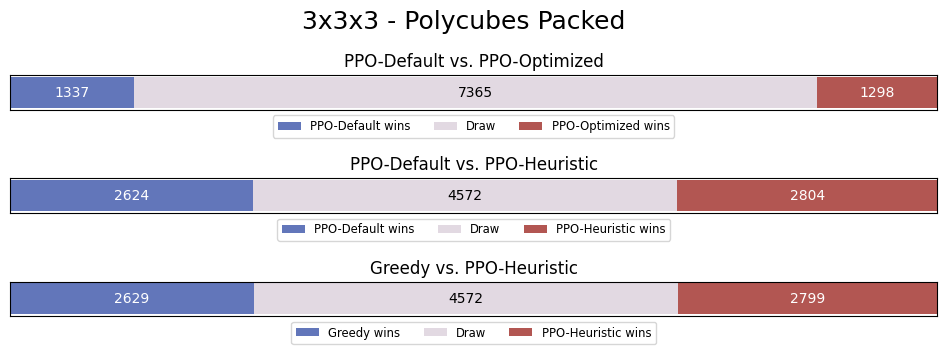

In [2]:
polycubes_packed_df = pd.read_csv('3x3x3-polycubes_packed.csv', index_col='seed')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 3))
fig.tight_layout()
fig.subplots_adjust(hspace=2)
fig.suptitle('3x3x3 - Polycubes Packed', fontsize=18, y=1.15)
colors = plt.colormaps['twilight_shifted'](np.linspace(0.25, 0.75, 3))

def compare(p1, p2, axis, t1, t2):
    head_to_head = polycubes_packed_df[p1] - polycubes_packed_df[p2]

    p1_win = head_to_head[head_to_head > 0].count()
    p1_win_mean = head_to_head[head_to_head > 0].mean()
    p2_win = head_to_head[head_to_head < 0].count()
    p2_win_mean = head_to_head[head_to_head < 0].mean()
    draw = head_to_head[head_to_head == 0].count()

    print(f'{p1} wins: {p1_win} with mean {p1_win_mean}')
    print(f'{p2} wins: {p2_win} with mean {p2_win_mean}')
    print(f'draws: {draw}')

    contingency_table = [[0, p1_win + draw], [p2_win + draw, 0]]
    result = mcnemar(contingency_table)
    print(f'p-value : {result.pvalue}', '\n')

    print(f'{p1} mean: {polycubes_packed_df[p1].mean()}')
    print(f'{p2} mean: {polycubes_packed_df[p2].mean()}')
    print(f'p-value: {ttest_rel(polycubes_packed_df[p1], polycubes_packed_df[p2]).pvalue}')

    for i, name in enumerate([f'{t1} wins', 'Draw', f'{t2} wins']):
        width = np.array([p1_win, draw, p2_win])[i]
        start = np.array([p1_win, draw, p2_win]).cumsum()[i] - width
        rects = axis.barh(' ', width, left=start, height=0.5, label=name, color=colors[i])
        r, g, b, _ = colors[i]
        text_color = 'white' if r * g * b < 0.5 else 'black'
        axis.bar_label(rects, label_type='center', color=text_color)
    axis.set_xlim(0, len(head_to_head))
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.legend(ncols=3, bbox_to_anchor=(0.5, 0), loc='upper center', fontsize='small')
    axis.title.set_text(f'{t1} vs. {t2}')

compare('ppo-d', 'ppo-o', ax1, 'PPO-Default', 'PPO-Optimized')
print('---------------------------------------------')
compare('ppo-d', 'ppo-h', ax2, 'PPO-Default', 'PPO-Heuristic')
print('---------------------------------------------')
compare('greedy', 'ppo-h', ax3, 'Greedy', 'PPO-Heuristic')

plt.plot()